In [63]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense

Load Dataset from Tensorflow Datasets and split into Train and Test

In [64]:
train_ds, test_ds = tfds.load('fashion_mnist', split=['train', 'test'], as_supervised=True)

Clean Pipeline Function

In [65]:
def prepare_fashion_dataset(data):
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # normalize inputs from 0/255 to -1/1
    data = data.map(lambda img, target: ((img/128.)-1, target))
    # create one-hot vector for targets
    data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # cache, shuffle, batch and prefetch data for efficient processing 
    data = data.cache()
    data = data.shuffle(1000)
    data = data.batch(32)
    data = data.prefetch(20)
    # return data
    return data
    

In [66]:
train_ds = prepare_fashion_dataset(train_ds)
test_ds =  prepare_fashion_dataset(test_ds)

Construct a model:

In [67]:
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        # convolution layer to create feature maps
        self.conv_layer_1 = Conv2D(64, (3,3), activation = 'relu',padding='same', input_shape=(28,28,1))
        self.conv_layer_2 = Conv2D(64, (3,3), activation = 'relu',padding='same', input_shape=(28,28,1))
        # pooling layer
        self.pool_layer_1 = MaxPooling2D(2,2)
        # taking the global average of previous values to feed to output function with classification
        self.averaging_layer = GlobalAveragePooling2D()
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.conv_layer_1(inputs)
        x = self.conv_layer_2(x)
        x = self.pool_layer_1(x)
        x = self.averaging_layer(x)
        x = self.out(x)
        return x
    

Training Step:

In [68]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

Testing Accuracy:

In [69]:
def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [70]:
tf.keras.backend.clear_session()


Training:

In [71]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.1


model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

2021-11-24 21:20:09.250568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 21:20:11.573560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch: 0 starting with accuracy 0.15115814696485624


2021-11-24 21:20:25.538710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 21:20:25.562959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch: 1 starting with accuracy 0.6217052715654952
Epoch: 2 starting with accuracy 0.7449081469648562
Epoch: 3 starting with accuracy 0.7714656549520766
Epoch: 4 starting with accuracy 0.8009185303514377
Epoch: 5 starting with accuracy 0.7790535143769968
Epoch: 6 starting with accuracy 0.8041134185303515
Epoch: 7 starting with accuracy 0.7999201277955271
Epoch: 8 starting with accuracy 0.8279752396166135
Epoch: 9 starting with accuracy 0.8304712460063898


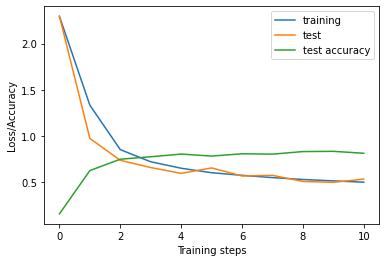

In [72]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()